In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.signal import find_peaks
from tqdm import tqdm

In [2]:
data = pd.read_csv('/kaggle/input/netflix-stock-prices/netflix_stock_prices.csv', index_col='date')
data.index = pd.to_datetime(data.index)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5865 entries, 2002-05-23 to 2025-09-12
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        5865 non-null   float64
 1   high        5865 non-null   float64
 2   low         5865 non-null   float64
 3   close       5865 non-null   float64
 4   volume      5865 non-null   int64  
 5   source_url  5865 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 320.7+ KB
None


open   high    low  close   volume  \
date                                              
2002-05-23  16.19  17.40  16.04  16.75  7485000   
2002-05-24  17.00  17.15  16.76  16.94   793200   
2002-05-28  16.99  17.25  16.20  16.20   472100   
2002-05-29  16.30  16.30  15.20  15.45   482700   
2002-05-30  15.51  15.51  15.00  15.00   725300   

                                                   source_url  
date                                                           
2002-05-23  https://www.alphavantage.co/query?function=TIM...  
2002-05-24  https://www.alphavantage.co/query?function=TIM...  
2002-05-28  https://www.alphavantage.co/query?function=TIM...  
2002-05-29  https://www.alphavantage.co/query?function=TIM...  
2002-05-30  https://www.alphavantage.co/query?function=TIM...

## 1. Анализ колебаний временного ряда

In [3]:
# интерактивный график временного ряда
def plot_ts(ts: pd.Series, title="Временной ряд"):
    fig = px.line(
        x=ts.index, y=ts.values, title=title, labels={"x": "Время", "y": "Значение"}
    )
    fig.update_layout(width=800, height=800)
    fig.show()

In [4]:
# исходный временной ряд
y=data['close']
plot_ts(y)

### Медленные движения

In [5]:
# логарифмирование временного ряда
y_log=np.log(y)
# медленные движения
plot_ts(y_log)

### Быстрые движения

Оптимальная дельта = 7


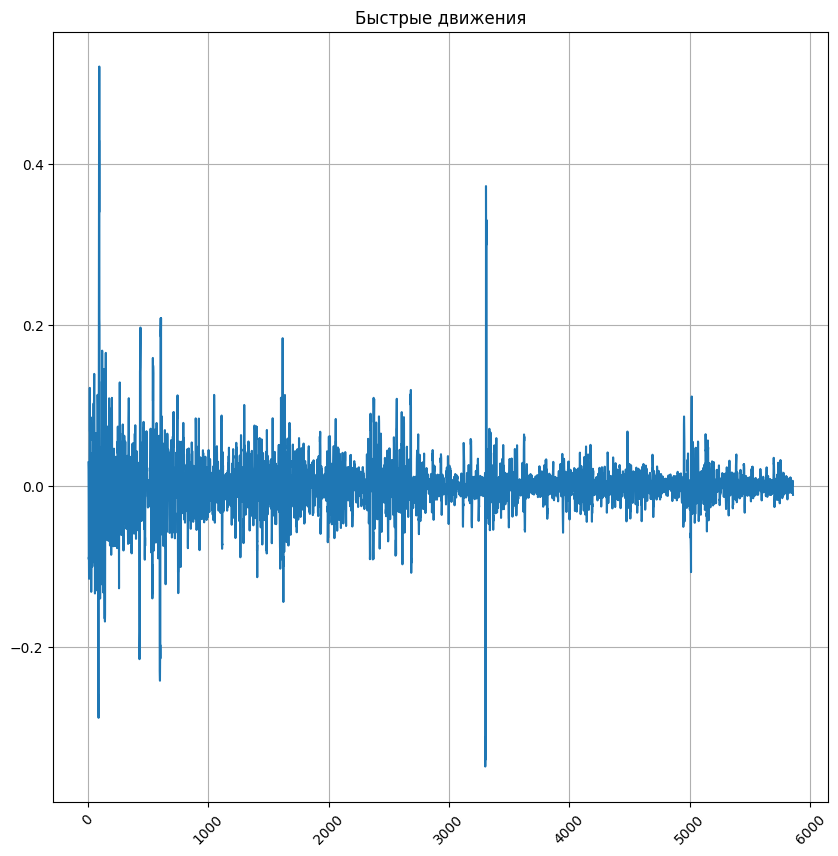

In [6]:
# исключение тренда
def remove_trend(y, delta=1):
    y_array = np.array(y)
    n = len(y_array)
    R = np.full(n, np.nan)
    for i in range(delta, n - delta):
        if y_array[i] > 0 and y_array[i - delta] > 0 and y_array[i + delta] > 0:
            R[i] = np.log((y_array[i + delta] * y_array[i - delta]) / (y_array[i]**2))
        else: 
            R[i] = np.nan
    return R

# подбор оптимальной дельты
max_delta = min(100, len(y_log) // 4)
deltas = np.arange(1, max_delta + 1)
metrics = []

for delta in deltas:
    R = remove_trend(y_log, delta)
    R_clean = R[~np.isnan(R)]
    if len(R_clean) == 0:
        metric = np.nan
    else:
        mean_val = np.mean(R_clean)
        max_amp = np.max(np.abs(R_clean))
        metric = mean_val / max_amp if max_amp != 0 else np.nan
    metrics.append(metric)

metrics = np.array(metrics)
valid = ~np.isnan(metrics)

if np.any(valid):
    optimal_idx = deltas[valid][np.argmin(np.abs(metrics[valid]))]
    print(f'Оптимальная дельта = {optimal_idx}')
else:
    print('Нет валидных метрик для выбора оптимальной дельты')

y_no_trend = remove_trend(y_log, 6)
plt.figure(figsize=(10,10))
plt.plot(y_no_trend)
plt.title('Быстрые движения')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [7]:
best_metric = 100
best_y = None
for delta_t in range(len(y) // 4):
    y_left = y.shift(-delta_t)
    y_right = y.shift(delta_t)

    y_sfift = np.log((y_left * y_right) / (y**2))
    metric = abs(y_sfift.mean() / (y_sfift.max() - y_sfift.min()))
    if metric < best_metric:
        best_metric = metric
        best_y = y_sfift
        print(
            "Достигнута новое лучшее значение метрики {}, при delta {}".format(
                metric, delta_t
            )
        )

/tmp/ipykernel_20/2576559897.py:8: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



Достигнута новое лучшее значение метрики 9.941581996003848e-07, при delta 1
Достигнута новое лучшее значение метрики 5.79943845885737e-07, при delta 6


In [8]:
# быстрые движения
plot_ts(best_y)

## 2. Анализ почти периодов

In [9]:
n = len(y)

delta_values = np.arange(10, 60, 1)
tau_values = np.arange(1, 1200, 1)

alter_jonson = np.zeros(shape=(len(delta_values), len(tau_values)))

for i, delta in enumerate(tqdm(delta_values, "Delta Loop")):
    for j, tau in enumerate(tqdm(tau_values, "Tau Loop", leave=False)):
        y_left = y.shift(-delta)
        y_right = y.shift(delta)
        y_shift = np.log((y_left * y_right) / (y**2))

        alter_jonson[i, j] = (1 / (n - tau - delta)) * np.sum(
            np.abs(y_shift.shift(-tau) - y_shift)
        )


alter_jonson

Tau Loop:   0%|          | 0/1199 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log


Delta Loop: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


array([[0.05928229, 0.08790872, 0.11047869, ..., 0.18035598, 0.18117268,
        0.18148607],
       [0.05850898, 0.08630663, 0.10848468, ..., 0.18951404, 0.19021925,
        0.18994667],
       [0.05851545, 0.08662502, 0.10866384, ..., 0.19854306, 0.19941284,
        0.19923966],
       ...,
       [0.05806344, 0.08570824, 0.10803032, ..., 0.4666101 , 0.46659402,
        0.46571125],
       [0.05780789, 0.08528573, 0.10701688, ..., 0.47028274, 0.47002305,
        0.46953237],
       [0.05843272, 0.08597389, 0.10661724, ..., 0.47411202, 0.47468111,
        0.47363443]])

In [10]:
df = pd.DataFrame(
    alter_jonson.T,
    columns=pd.Index(delta_values, name="delta"),
    index=pd.Index(tau_values, name="tau"),
)

fig = px.line(df, title="Сдвиговая функция")
fig.update_layout(
    xaxis_title="X-ось",
    yaxis_title="Y-ось",
    showlegend=False,
    width=800,
    height=800,
)
fig.show()

In [11]:
delta_grid, tau_grid = np.meshgrid(delta_values, tau_values, indexing="ij")

fig = go.Figure(
    data=[
        go.Surface(
            x=delta_grid,
            y=tau_grid,
            z=alter_jonson,
            colorscale="Rainbow",
            opacity=0.9,
            contours={
                "x": {"show": True, "color": "white", "width": 1},
                "y": {"show": True, "color": "white", "width": 1},
                "z": {"show": True, "color": "white", "width": 1},
            },
        )
    ]
)

fig.update_layout(
    title="Интерактивная зависимость функции от переменных delta_t и tau",
    scene=dict(
        xaxis_title="delta_t",
        yaxis_title="tаu",
        zaxis_title="a(delta_t,tau)",
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
    ),
    width=800,
    height=800,
    autosize=False,
)

fig.show()

## 3. Оценка трендовых характеристик

### Интенсивный рост

In [12]:
# построение анаморфозы интенсивного роста
y_anamorph_1 = 1 / y
plot_ts(y_anamorph_1)

In [13]:
from sklearn.linear_model import LinearRegression

# анаморфоза интенсивного роста
ts_anamorph_1 = 1 / y

# числовая ось времени (в днях с начала ряда)
base_time = ts_anamorph_1.index[0]
ts_numeric = (ts_anamorph_1.index - base_time).days
values = ts_anamorph_1.values
n = len(ts_anamorph_1)


In [14]:
def find_linear_decreasing_segments_fast(
    ts_numeric,
    values,
    min_len: int = 30,
    max_len: int = 365,
    step_start: int = 1,
    step_len: int = 1,
    r2_min: float = 0.0,
    require_decreasing: bool = True,
) -> pd.DataFrame:
    # В numpy-формат
    x = np.asarray(ts_numeric)
    y = np.asarray(values)
    n = len(y)

    if len(x) != n:
        raise ValueError("ts_numeric и values должны быть одинаковой длины")

    # Префиксные суммы: sum, sum x^2, sum y^2, sum x*y
    # префиксы длиной n+1, чтобы удобно брать суммy [start:end) как diff
    Sx   = np.zeros(n + 1)
    Sy   = np.zeros(n + 1)
    Sxx  = np.zeros(n + 1)
    Syy  = np.zeros(n + 1)
    Sxy  = np.zeros(n + 1)

    Sx[1:]  = np.cumsum(x)
    Sy[1:]  = np.cumsum(y)
    Sxx[1:] = np.cumsum(x * x)
    Syy[1:] = np.cumsum(y * y)
    Sxy[1:] = np.cumsum(x * y)

    results = []

    # Перебор стартовых точек
    for start in range(0, n - min_len + 1, step_start):
        max_len_here = min(max_len, n - start)
        if max_len_here < min_len:
            continue

        # Перебор длин окна
        for L in range(min_len, max_len_here + 1, step_len):
            end = start + L  # окно [start, end)

            # Суммы на окне
            Sx_w  = Sx[end]  - Sx[start]
            Sy_w  = Sy[end]  - Sy[start]
            Sxx_w = Sxx[end] - Sxx[start]
            Syy_w = Syy[end] - Syy[start]
            Sxy_w = Sxy[end] - Sxy[start]

            # Формулы линейной регрессии y = a x + b
            # a = (L * sum(xy) - sum(x)*sum(y)) / (L*sum(x^2) - (sum(x))^2)
            denom = L * Sxx_w - Sx_w * Sx_w
            if denom == 0:
                continue

            a = (L * Sxy_w - Sx_w * Sy_w) / denom
            b = (Sy_w - a * Sx_w) / L

            # Требование на убывание
            if require_decreasing and a >= 0:
                continue

            # Объяснённая и полная дисперсии
            # SST = sum( (y - mean_y)^2 ) = Syy - Sy^2 / L
            SST = Syy_w - (Sy_w * Sy_w) / L
            if SST <= 0:
                continue

            # SSE = sum( (y - (a x + b))^2 )
            # Расписываем аналитически:
            # SSE = Σy^2 - 2a Σxy - 2b Σy + a^2 Σx^2 + 2ab Σx + L b^2
            SSE = (
                Syy_w
                - 2 * a * Sxy_w
                - 2 * b * Sy_w
                + (a * a) * Sxx_w
                + 2 * a * b * Sx_w
                + L * (b * b)
            )

            r2 = 1 - SSE / SST

            if not np.isfinite(r2):
                continue
            if r2 < r2_min:
                continue

            results.append(
                {
                    "x": start,
                    "delta": L - 1,
                    "r_2": float(r2),
                    "slope": float(a),
                    "intercept": float(b),
                }
            )

    if not results:
        return pd.DataFrame(columns=["x", "delta", "r_2", "slope", "intercept"])

    return pd.DataFrame(results)

In [15]:
intense_data = find_linear_decreasing_segments_fast(
    ts_numeric=ts_numeric,
    values=values,
    min_len=60,
    max_len=365,
    step_start=5, 
    step_len=3,
    r2_min=0.8,
    require_decreasing=True,
)

intense_data.to_csv("intense_growth_res.csv", index=False)
intense_data.head()

x  delta       r_2     slope  intercept
0  60    356  0.801322 -0.000203   0.127425
1  60    359  0.803205 -0.000202   0.127167
2  60    362  0.805226 -0.000201   0.126929
3  65    314  0.800888 -0.000226   0.134235
4  65    317  0.802651 -0.000224   0.133908

In [16]:
def choose_best_nonoverlapping_intervals(data: pd.DataFrame, n: int = 1):
    results = []
    for _ in range(n):
        row = data.nlargest(1, columns="r_2")
        results.append(row)

        x_val = int(row.iloc[0]["x"])
        delta_val = int(row.iloc[0]["delta"])

        # Фильтруем данные, исключая перекрывающиеся интервалы
        data = data.query(f"x > {x_val + delta_val} or x + delta < {x_val}")
    return pd.concat(results, ignore_index=True)

In [17]:
top_segments = choose_best_nonoverlapping_intervals(
    intense_data.query("delta >= 60 and r_2 > 0.8"), 3
)
top_segments

x  delta       r_2     slope  intercept
0  3645     62  0.964317 -0.000020   0.116500
1  1935     98  0.963392 -0.000064   0.196431
2  2590    131  0.949252 -0.000073   0.291891

In [18]:
# Извлекаем параметры лучшего отрезка
colors = ["red", "green", "purple"]
idx_to_time = ts_anamorph_1.index
base_time = ts_anamorph_1.index[0]
ts_numeric = (ts_anamorph_1.index - base_time).days

# Создаем фигуру
fig = go.Figure()

# Добавляем весь временной ряд
fig.add_trace(
    go.Scatter(
        x=ts_anamorph_1.index,
        y=ts_anamorph_1.values,
        mode="lines",
        name="Временной ряд",
        line=dict(color="lightblue", width=1),
        opacity=0.7,
    )
)
for i, (_, segment) in enumerate(top_segments.iterrows()):
    start = int(segment["x"])
    end = int(start + segment["delta"])
    segment_data = ts_anamorph_1.iloc[start : end + 1]

    # Строим регрессию
    X = ts_numeric[start : end + 1].to_numpy().reshape(-1, 1)
    y_l= segment_data.values

    model = LinearRegression()
    model.fit(X, y_l)
    y_pred = model.predict(X)
    x_star = -model.intercept_ / model.coef_[0]
    t_star = base_time + pd.Timedelta(days=x_star)
    r_2 = model.score(X, y_l)

    # Добавляем исходные данные участка
    fig.add_trace(
        go.Scatter(
            x=segment_data.index,
            y=segment_data.values,
            mode="lines+markers",
            name=f"Участок {i + 1}, R_2 = {r_2:.3f}",
            line=dict(color=colors[i], width=3),
            marker=dict(size=4, color=colors[i]),
        )
    )

    # Добавляем линию регрессии
    fig.add_trace(
        go.Scatter(
            x=segment_data.index,
            y=y_pred,
            mode="lines",
            name=f"Регрессия, t*={t_star:%d-%m-%Y}",
            line=dict(color=colors[i], width=2),
            opacity=0.8,
        )
    )

fig.update_layout(
    title="Временной ряд с линейными участками и регрессиями",
    xaxis_title="Время",
    yaxis_title="Значение",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99),
    hovermode="x unified",
    width=800,
    height=800,  # Увеличиваем высоту для лучшего отображения легенды
)

fig.show()

In [19]:
idx_to_data = y_anamorph_1.index
intervals = [
    ("2010-01-25", "2010-08-07"),
    ("2012-09-25", "2013-03-10"),
    ("2016-11-20", "2017-02-15"),
]

intervals_indexed = []
for interval in intervals:
    intervals_indexed.append(idx_to_data.get_indexer(interval))
intervals_indexed

[array([1931,   -1]), array([2605,   -1]), array([  -1, 3709])]

In [20]:
top_segments = pd.DataFrame(intervals_indexed, columns=["x", "y"])
top_segments["delta"] = top_segments["y"] - top_segments["x"]
top_segments

x     y  delta
0  1931    -1  -1932
1  2605    -1  -2606
2    -1  3709   3710

### Ограниченный рост

In [21]:
# построение анаморфозы ограниченного роста
y_anamorph_2 = np.log(y / y.cumsum())
plot_ts(y_anamorph_2)

In [22]:
ts_anamorph_2 = y_anamorph_2.copy()
base_time = ts_anamorph_2.index[0]
ts_numeric_2 = (ts_anamorph_2.index - base_time).days
values_2 = ts_anamorph_2.values
n = len(y_anamorph_2)

limited_data = find_linear_decreasing_segments_fast(
    ts_numeric=ts_numeric_2,
    values=values_2,
    min_len=60,
    max_len=365,
    step_start=5, 
    step_len=3,
    r2_min=0.8,
    require_decreasing=True,
)

limited_data.to_csv("limited_growth_res.csv", index=False)
limited_data.head()

x  delta       r_2     slope  intercept
0  0     59  0.852685 -0.034910  -1.689198
1  0     62  0.843513 -0.033091  -1.743755
2  0     65  0.835431 -0.031482  -1.794073
3  0     68  0.834522 -0.030280  -1.833432
4  0     71  0.828962 -0.028945  -1.879453

In [23]:
top_segments = choose_best_nonoverlapping_intervals(
    limited_data.query("delta >= 60 and r_2 > 0.8"), 3
)
top_segments

x  delta       r_2     slope  intercept
0  2295    110  0.960888 -0.011912  33.881040
1    15     86  0.951056 -0.017925  -2.640098
2   345    326  0.937508 -0.005935  -1.773365

In [24]:
# Извлекаем параметры лучшего отрезка
colors = ["red", "orange", "yellow"]
idx_to_time = ts_anamorph_2.index
base_time = ts_anamorph_2.index[0]
ts_numeric = (ts_anamorph_2.index - base_time).days

# Создаем фигуру
fig = go.Figure()

# Добавляем весь временной ряд
fig.add_trace(
    go.Scatter(
        x=ts_anamorph_2.index,
        y=ts_anamorph_2.values,
        mode="lines",
        name="Временной ряд",
        line=dict(color="black", width=1),
        opacity=1.0,
    )
)

for i, (_, segment) in enumerate(top_segments.iterrows()):
    start = int(segment["x"])
    end = int(start + segment["delta"])
    segment_data = ts_anamorph_2.iloc[start : end + 1]

    # Строим регрессию
    X = ts_numeric[start : end + 1].to_numpy().reshape(-1, 1)
    y_l = segment_data.values

    model = LinearRegression()
    model.fit(X, y_l)
    y_pred = model.predict(X)
    r_2 = model.score(X, y_l)
    # tau = 25 * np.pi/ 180
    # tau = -np.arctan(model.coef_[0])
    k = model.coef_[0] 
    y_tau = np.log(-k)

    t_star_idx = (y_tau - model.intercept_) / k
    t_star = base_time + pd.Timedelta(days=t_star_idx)

    # Добавляем исходные данные участка
    fig.add_trace(
        go.Scatter(
            x=segment_data.index,
            y=segment_data.values,
            mode="lines+markers",
            name=f"Участок {i + 1} (R²={r_2:.3f})",
            line=dict(color=colors[i], width=3),
            marker=dict(size=4, color=colors[i]),
        )
    )

    # Добавляем линию регрессии
    fig.add_trace(
        go.Scatter(
            x=segment_data.index,
            y=y_pred,
            mode="lines",
            name=f"Регрессия, tau={tau:3f}, t*={t_star:%d-%m-%Y}",
            line=dict(color=colors[i], width=2),
            opacity=0.8,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[ts_anamorph_2.index[0], ts_anamorph_2.index[-1]],
            y=[y_tau, y_tau],
            mode="lines",
            name=f"ln(-w{i + 1})",
            line=dict(color=colors[i], width=1, dash="dot"),
            opacity=0.6,
        )
    )


fig.update_layout(
    title="Временной ряд с линейными участками и регрессиями",
    xaxis_title="Время",
    yaxis_title="Значение",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99),
    hovermode="x unified",
    width=800,
    height=800,
)

fig.show()

In [25]:
idx_to_data = ts_anamorph_2.index
intervals = [
    ("2002-05-18", "2002-10-10"),
    ("2003-11-11", "2005-02-20"),
    ("2011-12-01", "2011-12-23"),
]

intervals_indexed = []
for interval in intervals:
    intervals_indexed.append(idx_to_data.get_indexer(interval))
intervals_indexed

[array([-1, 97]), array([371,  -1]), array([2400, 2416])]

In [26]:
top_segments = pd.DataFrame(intervals_indexed, columns=["x", "y"])
top_segments["delta"] = top_segments["y"] - top_segments["x"]
top_segments

x     y  delta
0    -1    97     98
1   371    -1   -372
2  2400  2416     16

## 4. Прогнозирование

In [27]:
intense_data.query("x+delta>=5855").nlargest(10, "r_2")

x  delta       r_2     slope  intercept
25891  5505    350  0.933423 -0.000002   0.017294
25830  5500    356  0.933413 -0.000002   0.017130
25831  5500    359  0.933368 -0.000002   0.017047
25832  5500    362  0.933340 -0.000002   0.016966
25772  5495    362  0.933248 -0.000002   0.016964
25892  5505    353  0.933140 -0.000002   0.017201
25893  5505    356  0.933061 -0.000002   0.017117
25955  5510    347  0.932632 -0.000002   0.017352
25956  5510    350  0.932492 -0.000002   0.017263
25894  5505    359  0.932206 -0.000002   0.017011

In [28]:
final_interval = intense_data.query("x+delta>=5855").nlargest(1, "r_2")
start = final_interval.iat[0, 0]
end = start + final_interval.iat[0, 1]

segment_data = ts_anamorph_1.iloc[start : end + 1]

X = np.arange(start, end + 1).reshape(-1, 1)
y_l = segment_data.values

model = LinearRegression()
model.fit(X, y_l)

LinearRegression()

In [29]:
t_star = int(-model.intercept_ / model.coef_[0])
t_star

6100

In [30]:
start_forecast = ts_anamorph_1.index.size + 1
delta_forecast = 90
y_trend_forecast = 1 / model.predict(
    np.arange(start_forecast, start_forecast + delta_forecast).reshape(-1, 1)
)
y_trend_forecast

array([1491.07089992, 1497.44682314, 1503.8775083 , 1510.36366398,
       1516.906011  , 1523.50528274, 1530.1622254 , 1536.87759827,
       1543.65217404, 1550.48673907, 1557.38209372, 1564.33905264,
       1571.35844513, 1578.4411154 , 1585.58792298, 1592.79974302,
       1600.07746668, 1607.42200148, 1614.83427166, 1622.31521861,
       1629.86580124, 1637.48699639, 1645.17979925, 1652.94522381,
       1660.78430331, 1668.69809064, 1676.68765891, 1684.75410183,
       1692.8985343 , 1701.12209285, 1709.42593622, 1717.81124589,
       1726.27922662, 1734.83110706, 1743.46814031, 1752.19160456,
       1761.00280372, 1769.90306804, 1778.89375481, 1787.97624905,
       1797.15196419, 1806.42234283, 1815.78885751, 1825.25301144,
       1834.81633936, 1844.48040833, 1854.2468186 , 1864.11720449,
       1874.09323533, 1884.17661634, 1894.36908966, 1904.67243533,
       1915.08847233, 1925.61905964, 1936.26609735, 1947.03152782,
       1957.91733684, 1968.92555488, 1980.05825829, 1991.31757

In [31]:
no_trend_result = best_y.dropna()
coefs = [5, 2, 1]
periods = [140, 605, 746, 940]
y_curcuit_forecast = []
for i in range(delta_forecast):
    currcuit_sum = 0
    for j in range(len(coefs)):
        currcuit_sum += no_trend_result.iloc[-periods[j] + i]
    y_curcuit_forecast.append(currcuit_sum)

y_curcuit_forecast = np.array(y_curcuit_forecast)

In [32]:
#y_forecast = y_trend_forecast + 10 * y_curcuit_forecast

delta_forecast = 90
# Уровень – последняя наблюдаемая цена
level = y.iloc[-1]

# или сглаженное среднее за последний год:
#level = y.iloc[-100:].mean()

# Прогноз только по циклу:
y_forecast = level + y_curcuit_forecast*100

In [33]:
delta_forecast = 90

# 1. Уровень – пусть будет среднее за последний год
level = y.iloc[-365:].mean()

# 2. Циклическая компонента – возьмём последний «период» best_y
no_trend_result = best_y.dropna()

period = 140  # оценка доминирующего периода
cycle_tail = no_trend_result.iloc[-period:]  # последний цикл

# повторяем этот цикл вперёд на горизонт прогноза
repeats = int(np.ceil(delta_forecast / period))
y_cycle_forecast = np.tile(cycle_tail.values, repeats)[:delta_forecast]

# 3. Масштабируем цикл, чтобы его амплитуда была сопоставима с прошлой
hist_std = no_trend_result.iloc[-500:].std()
forecast_std = y_cycle_forecast.std()
if forecast_std > 0:
    scale = hist_std / forecast_std
else:
    scale = 1.0

y_cycle_forecast = scale * y_cycle_forecast

# 4. Итоговый прогноз: уровень + цикл
y_forecast = level + y_cycle_forecast

In [34]:
# Создаем даты для прогноза (продолжаем от последней даты исходного ряда)
y=data['close']
last_date = y.index[-1]
forecast_dates = pd.date_range(
    start=pd.to_datetime(last_date) + pd.Timedelta(days=1),
    periods=len(y_trend_forecast),
    freq=pd.infer_freq(y.index),  # определяем частоту из исходного ряда
)

# Создаем график
fig = go.Figure()

# Добавляем исходный временной ряд
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y.values,
        mode="lines",
        name="Исходный ряд",
        line=dict(color="blue"),
    )
)

# Добавляем прогноз
fig.add_trace(
    go.Scatter(
        x=forecast_dates,
        y=y_forecast,
        mode="lines",
        name="Прогноз",
        line=dict(color="red"),
    )
)

# Настраиваем layout
fig.update_layout(
    title="Временной ряд и прогноз",
    xaxis_title="Дата",
    yaxis_title="Значение",
    hovermode="x unified",
    showlegend=True,
)

# Показываем график
fig.show()

In [35]:
print(y_curcuit_forecast[:10])
print("mean:", np.mean(y_curcuit_forecast), "std:", np.std(y_curcuit_forecast))

[-0.09730252 -0.20524841 -0.21449195 -0.18631561 -0.12922888 -0.09436424
 -0.03612226  0.16440306  0.15192067  0.16974207]
mean: 0.002749251091028001 std: 0.19166768012789154


### Старое

In [36]:
# функция Альтера-Джонса
def alter_jones_function(f, tau_max=100):
    n = len(f)
    a_tau = np.zeros(tau_max)
    
    for tau in range(1, tau_max + 1):
        if tau >= n:
            break
        sum_val = 0
        count = 0
        for t in range(n - tau):
            if not np.isnan(f[t]) and not np.isnan(f[t + tau]):
                sum_val += abs(f[t + tau] - f[t])
                count += 1
        a_tau[tau - 1] = sum_val / count if count > 0 else np.nan
    
    return a_tau

# обобщенная сдвиговая функция
def generalized_shift_function(y, delta_t_values, tau_max=100):
    results = {}
    
    for delta_t in delta_t_values:
        # Получаем колебания для данной дельты
        R = remove_trend(y, delta_t)
        R_clean = R[~np.isnan(R)]
        
        if len(R_clean) > tau_max:
            # Применяем функцию Альтера-Джонса
            a_tau = alter_jones_function(R_clean, tau_max)
            results[delta_t] = a_tau
    
    return results


delta_t=7: выявлены почти-периоды:
  tau_1=18 дней (0.07 лет), a(tau)=0.0355
  tau_2=34 дней (0.13 лет), a(tau)=0.0355
  tau_3=53 дней (0.21 лет), a(tau)=0.0355
  tau_4=67 дней (0.27 лет), a(tau)=0.0352

delta_t=14: выявлены почти-периоды:
  tau_1=72 дней (0.29 лет), a(tau)=0.0504

delta_t=21: выявлены почти-периоды:
  tau_1=60 дней (0.24 лет), a(tau)=0.0613


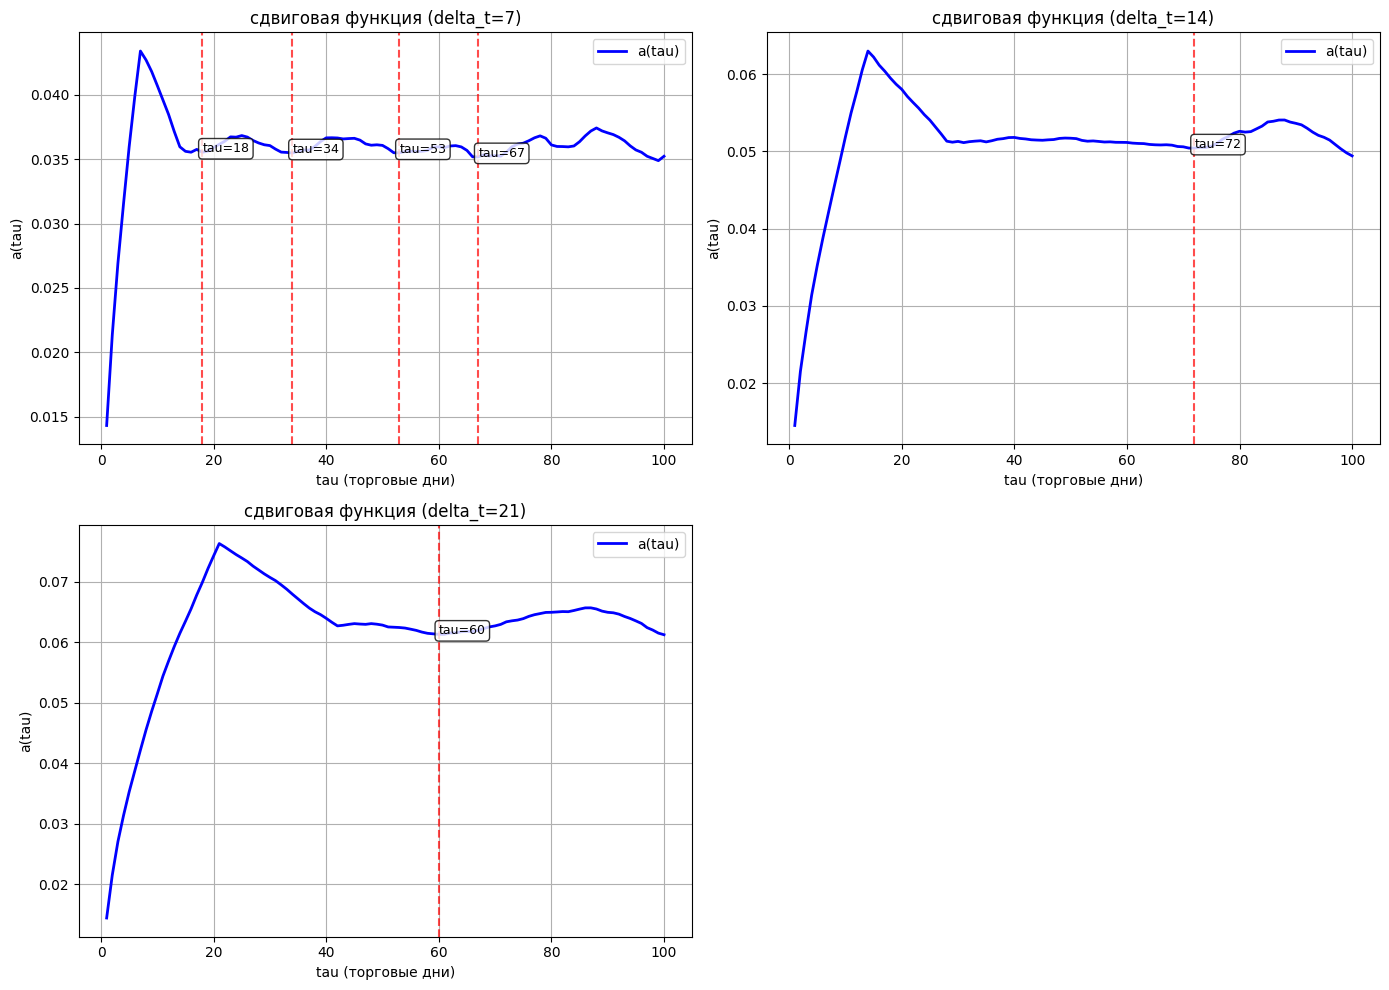

In [37]:
delta_t_values = [optimal_idx, optimal_idx*2, optimal_idx*3]
tau_max = min(100, len(y_no_trend[~np.isnan(y_no_trend)]) // 2)

# вычисляем сдвиговую функцию для разных Δt
shift_results = {}
for delta_t in delta_t_values:
    r_values = remove_trend(y_log, delta_t)
    r_clean = r_values[~np.isnan(r_values)]
    
    if len(r_clean) > tau_max:
        a_tau = alter_jones_function(r_clean, tau_max)
        shift_results[delta_t] = a_tau

# визуализация с пояснениями
plt.figure(figsize=(14, 10))
for i, (delta_t, a_tau) in enumerate(shift_results.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(1, len(a_tau) + 1), a_tau, 'b-', linewidth=2, label='a(tau)')
    plt.title(f'сдвиговая функция (delta_t={delta_t})')
    plt.xlabel('tau (торговые дни)')
    plt.ylabel('a(tau)')
    plt.grid(True)
    
    # находим локальные минимумы - почти-периоды
    peaks, _ = find_peaks(-a_tau, prominence=0.1*np.nanstd(a_tau))
    
    if len(peaks) > 0:
        # фильтруем значимые минимумы (ниже 25% перцентиля)
        significant_peaks = peaks[a_tau[peaks] < np.nanpercentile(a_tau, 25)]
        
        print(f"\ndelta_t={delta_t}: выявлены почти-периоды:")
        for j, peak in enumerate(significant_peaks[:4]):  # берем до 4 наиболее значимых
            tau_value = peak + 1
            a_value = a_tau[peak]
            
            # отмечаем на графике
            plt.axvline(x=tau_value, color='red', linestyle='--', alpha=0.7)
            plt.text(tau_value, a_value, f'tau={tau_value}', fontsize=9, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # переводим в годы для интерпретации
            years = tau_value / 252
            print(f"  tau_{j+1}={tau_value} дней ({years:.2f} лет), a(tau)={a_value:.4f}")
            
    plt.legend()

plt.tight_layout()
plt.show()

Количество найденных t* = 212
0: t≈[303, 322], R²=0.9690, a=-0.0007367, b=0.2669, t*≈362.31
1: t≈[304, 323], R²=0.9789, a=-0.0007572, b=0.2734, t*≈361.14
2: t≈[305, 324], R²=0.9814, a=-0.0007627, b=0.2753, t*≈360.95
3: t≈[306, 325], R²=0.9772, a=-0.0007534, b=0.2725, t*≈361.68
4: t≈[307, 326], R²=0.9646, a=-0.0007282, b=0.2647, t*≈363.43
Выбранный сегмент роста: t≈[303, 322], a=-0.0007367, b=0.2669, R²=0.9690, t*≈362.31


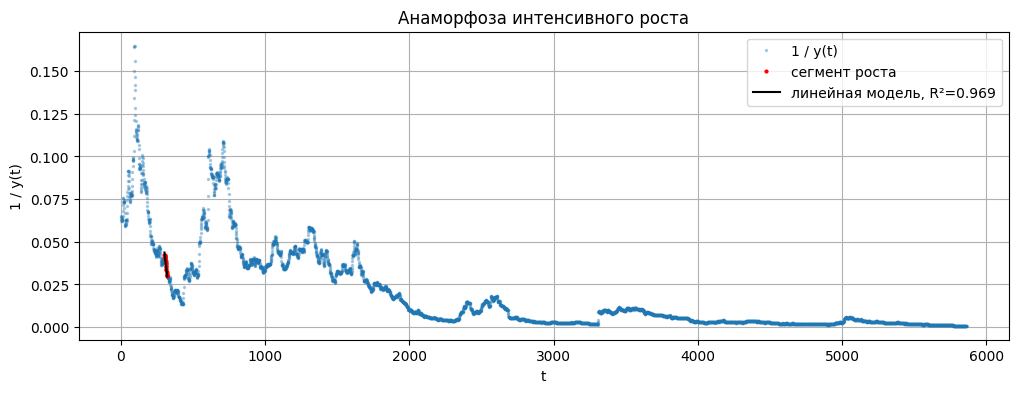

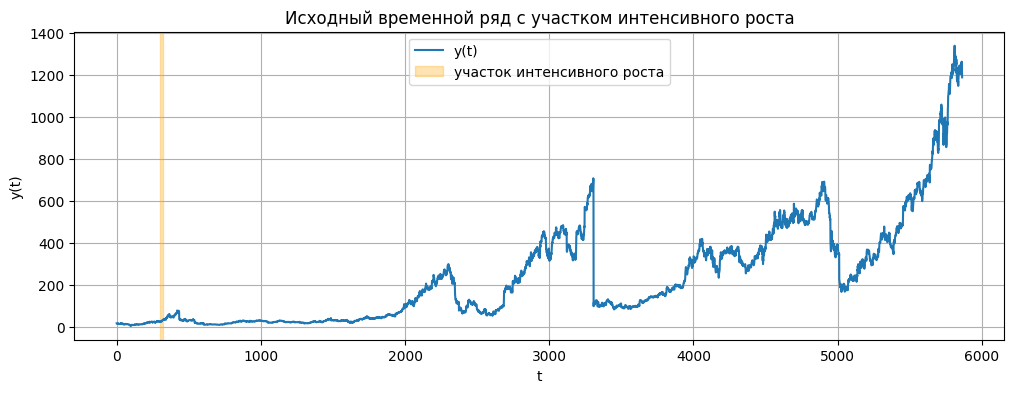

In [38]:
from sklearn.linear_model import LinearRegression

t = np.arange(len(y))  
y_s = pd.Series(y).rolling(window=5, center=True).mean().to_numpy()
mask = ~np.isnan(y_s)
t = t[mask]
y_s = y_s[mask]
dy_dt = np.gradient(y_s, t)
def find_growth_segments(t, y_s, window=40, r2_min=0.95):
    inv_y = 1.0 / y_s
    segs = []
    n = len(t)

    for start in range(0, n - window + 1):
        end = start + window
        
        y_win = y_s[start:end]
        inv_win = inv_y[start:end]
        t_win = t[start:end].reshape(-1, 1)
        
        if y_win[-1] <= y_win[0]:
            continue  
       
        model = LinearRegression().fit(t_win, inv_win)
        a = float(model.coef_[0])
        b = float(model.intercept_)
        r2 = model.score(t_win, inv_win)
        
        if a >= 0:
            continue

        if r2 >= r2_min:
            t_star = -b / a 
            segs.append({
                "start": start,
                "end": end,
                "a": a,
                "b": b,
                "r2": r2,
                "t_star": t_star,
            })

    return segs

growth_segments = find_growth_segments(t, y_s, window=20, r2_min=0.95)
print(f'Количество найденных t* = {len(growth_segments)}')
for i, seg in enumerate(growth_segments[:5]):
    s, e = seg["start"], seg["end"]
    print(f"{i}: t≈[{t[s]}, {t[e-1]}], R²={seg['r2']:.4f}, "
          f"a={seg['a']:.4g}, b={seg['b']:.4g}, t*≈{seg['t_star']:.2f}")

if growth_segments:
    seg = growth_segments[0]
    s, e = seg["start"], seg["end"]
    a, b, r2, t_star = seg["a"], seg["b"], seg["r2"], seg["t_star"]

    print(f"Выбранный сегмент роста: t≈[{t[s]}, {t[e-1]}], "
          f"a={a:.4g}, b={b:.4g}, R²={r2:.4f}, t*≈{t_star:.2f}")

    inv_y = 1.0 / y_s

    plt.figure(figsize=(12,4))
    plt.plot(t, inv_y, '.', ms=3, alpha=0.3, label="1 / y(t)")
    plt.plot(t[s:e], inv_y[s:e], 'r.', ms=4, label="сегмент роста")

    xs = t[s:e]
    ys_fit = a * xs + b
    plt.plot(xs, ys_fit, 'k-', label=f"линейная модель, R²={r2:.3f}")


    plt.xlabel("t")
    plt.ylabel("1 / y(t)")
    plt.title("Анаморфоза интенсивного роста")
    plt.legend()
    plt.grid(True)
    plt.show()

    t_full = np.arange(len(y))

    plt.figure(figsize=(12,4))
    plt.plot(t_full, y, label="y(t)")

    plt.axvspan(t[s], t[e-1], color='orange', alpha=0.3, label="участок интенсивного роста")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Исходный временной ряд с участком интенсивного роста")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Гиперболических участков роста (по нашим критериям) не найдено.")


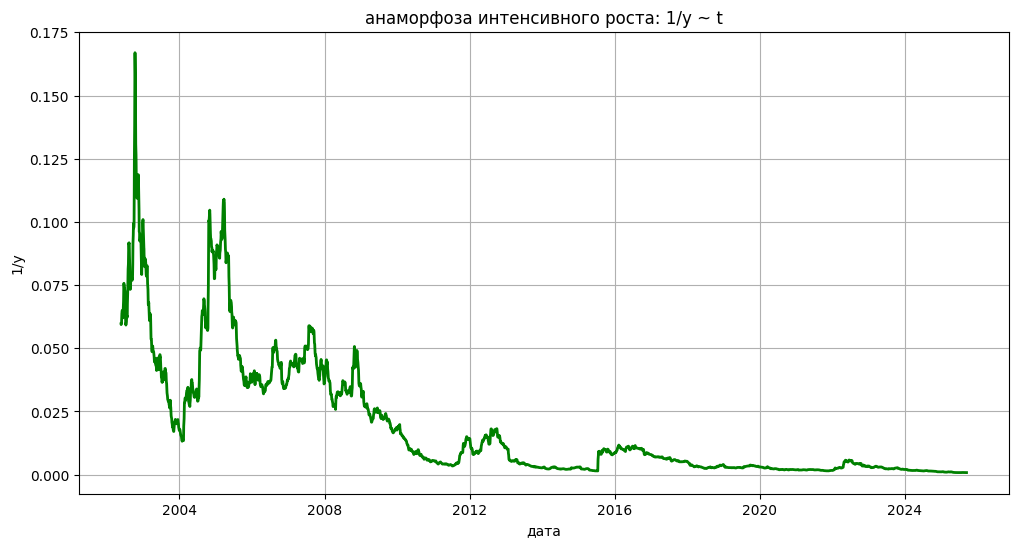

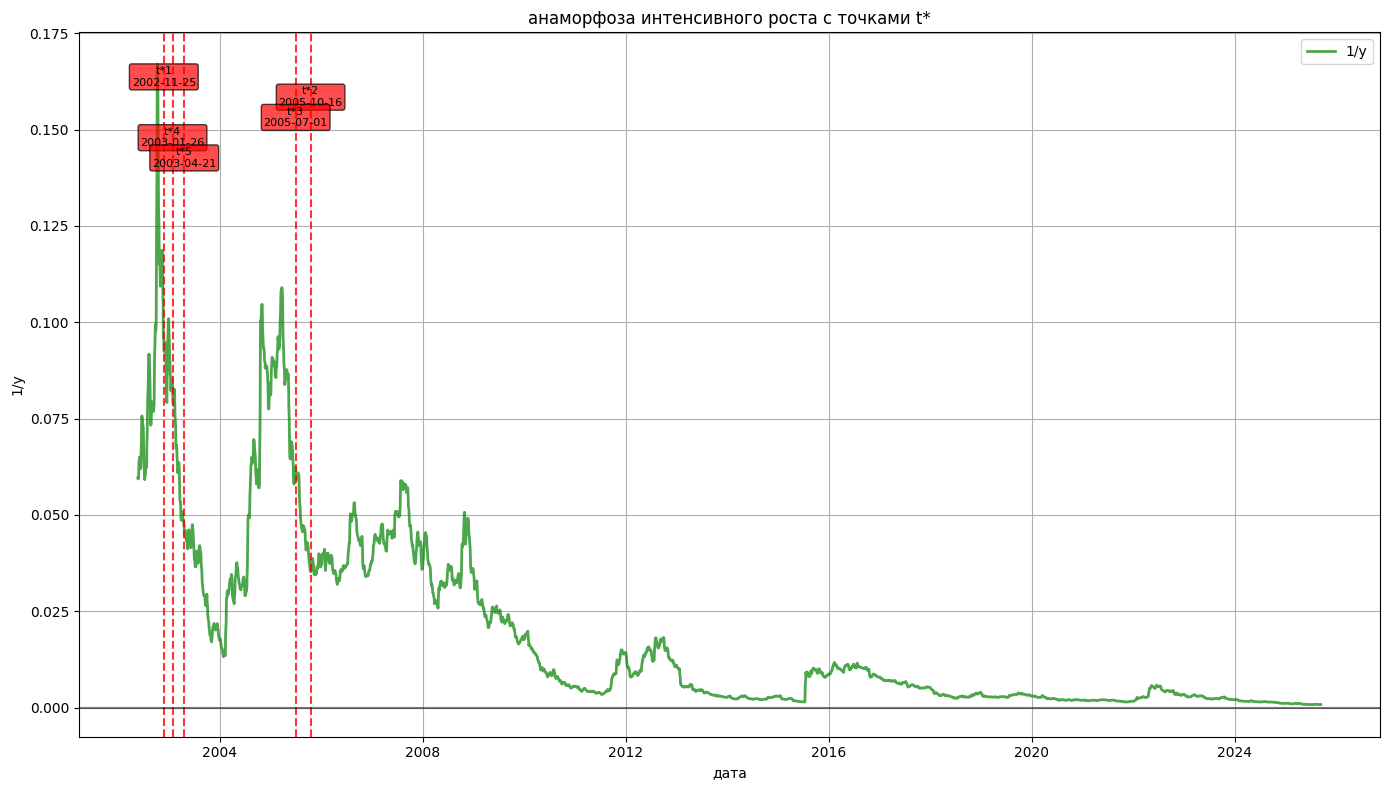

найдены точки завершения интенсивного роста t*:
t*1: 2002-11-25 (прошлое), цена = 11.10
t*2: 2005-10-16 (прошлое), цена = 29.10
t*3: 2005-07-01 (прошлое), цена = 16.55
t*4: 2003-01-26 (прошлое), цена = 12.28
t*5: 2003-04-21 (прошлое), цена = 24.63


In [39]:
# построение анаморфозы интенсивного роста
#y = y[:2500]
y_inv = np.zeros(len(y)) # анаморфоза интенсивного роста: 1/y
for i in range(len(y)):
    if abs(y.iloc[i]) > 1e-10:
        y_inv[i] = 1 / abs(y.iloc[i])
    else:
        y_inv[i] = np.nan

# создаем Series с правильными индексами
y_inv_series = pd.Series(y_inv, index=y.index)

# сглаживаем для лучшего анализа
y_inv_smooth = y_inv_series.rolling(window=5, min_periods=1).mean()

# строим анаморфозу
plt.figure(figsize=(12, 6))
plt.plot(y_inv_smooth.index, y_inv_smooth.values, 'g-', linewidth=2)
plt.title('анаморфоза интенсивного роста: 1/y ~ t')
plt.ylabel('1/y')
plt.xlabel('дата')
plt.grid(True)
plt.show()

# находим линейные участки и точки пересечения с осью X
clean_mask = ~np.isnan(y_inv_smooth.values)
clean_inv = y_inv_smooth.values[clean_mask]
clean_dates = y_inv_smooth.index[clean_mask]

t_star_candidates = []

if len(clean_inv) > 10:
    # разбиваем на перекрывающиеся сегменты
    segment_size = 20
    
    for start_idx in range(0, len(clean_inv) - segment_size, 5):  # уменьшил шаг для большего охвата
        end_idx = start_idx + segment_size
        segment_values = clean_inv[start_idx:end_idx]
        
        if len(segment_values) > 5:
            # линейная регрессия
            x_numeric = np.arange(len(segment_values))
            slope, intercept, r_value, _, _ = stats.linregress(x_numeric, segment_values)
            
            # более строгие критерии для лучших кандидатов
            if r_value**2 > 0.8 and slope < -1e-6:  # увеличил R² и чувствительность наклона
                
                if slope != 0:
                    x_intersect = -intercept / slope
                    
                    # проверяем, что пересечение в разумных пределах
                    if len(segment_values) < x_intersect < len(clean_inv) * 1.5:
                        
                        # вычисляем дату пересечения
                        segment_dates = clean_dates[start_idx:end_idx]
                        date_delta = segment_dates[1] - segment_dates[0] if len(segment_dates) > 1 else pd.Timedelta(days=1)
                        
                        t_star_date = segment_dates[0] + date_delta * x_intersect
                        
                        # качество аппроксимации (чем лучше R², тем выше приоритет)
                        quality_score = r_value**2 * abs(slope)  # комбинированная метрика
                        
                        t_star_candidates.append({
                            'date': t_star_date,
                            'quality': quality_score,
                            'r_squared': r_value**2,
                            'slope': slope
                        })

# сортируем кандидатов по качеству и выбираем лучшие 15
if t_star_candidates:
    t_star_candidates.sort(key=lambda x: x['quality'], reverse=True)
    
    # фильтруем уникальные даты (разница > 30 дней)
    t_star_dates = []
    for candidate in t_star_candidates:
        if not t_star_dates or all(abs((candidate['date'] - existing_date).days) > 30 
                                 for existing_date in t_star_dates):
            t_star_dates.append(candidate['date'])
        
        # останавливаемся когда набрали 15 точек
        if len(t_star_dates) >= 5:
            break

# строим финальный график с результатами
plt.figure(figsize=(14, 8))
plt.plot(clean_dates, clean_inv, 'g-', linewidth=2, label='1/y', alpha=0.7)
plt.title('анаморфоза интенсивного роста с точками t*')
plt.ylabel('1/y')
plt.xlabel('дата')
plt.grid(True)

# отмечаем точки t*
for i, t_date in enumerate(t_star_dates):
    plt.axvline(x=t_date, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
    y_pos = plt.ylim()[1] * (0.95 - i * 0.03)  # распределяем надписи по вертикали
    plt.text(t_date, y_pos, f't*{i+1}\n{t_date.strftime("%Y-%m-%d")}', 
             fontsize=8, ha='center', va='top',
             bbox=dict(boxstyle="round,pad=0.2", facecolor="red", alpha=0.7))

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# выводим результаты
print(f"найдены точки завершения интенсивного роста t*:")
for i, t_date in enumerate(t_star_dates):
    # находим ближайшую цену к этой дате
    time_diffs = [(date - t_date).total_seconds() for date in y.index]
    closest_idx = np.argmin(np.abs(time_diffs))
    price_at_t = y.iloc[closest_idx]
    days_from_now = (t_date - pd.Timestamp.now()).days
    
    status = "прошлое" if days_from_now < 0 else "будущее"
    print(f"t*{i+1}: {t_date.strftime('%Y-%m-%d')} ({status}), цена = {price_at_t:.2f}")

Количество найденных сегментов = 98
0: t≈[2568, 2581], R²=0.9848, slope=0.01293, intercept=-34.87
1: t≈[5565, 5587], R²=0.9827, slope=-0.004887, intercept=27.19
2: t≈[1408, 1424], R²=0.9813, slope=-0.01511, intercept=20.26
3: t≈[3818, 3838], R²=0.9805, slope=-0.006114, intercept=22.06
4: t≈[1373, 1386], R²=0.9804, slope=-0.01562, intercept=20.43
Выбранный сегмент: t≈[2568, 2581], slope=0.01293, intercept=-34.87, R²=0.9848
t*≈2360.98, ln(K)=-4.3483, K=-0.01293


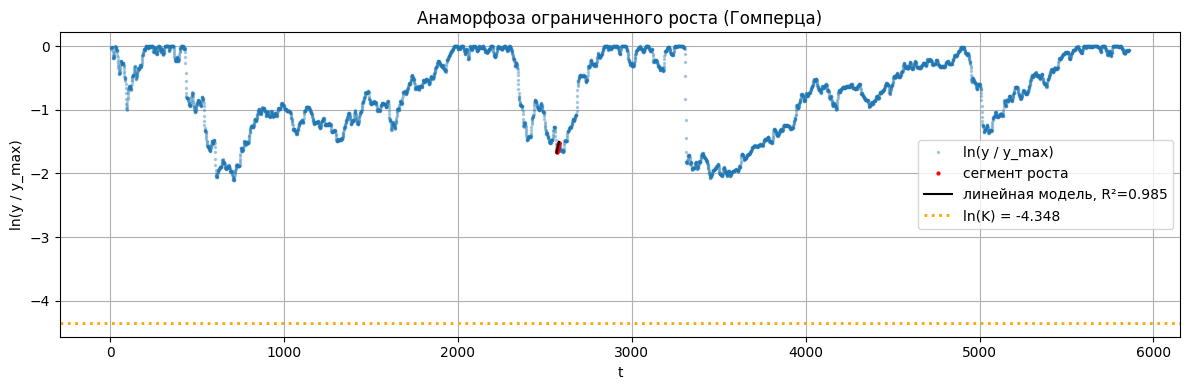

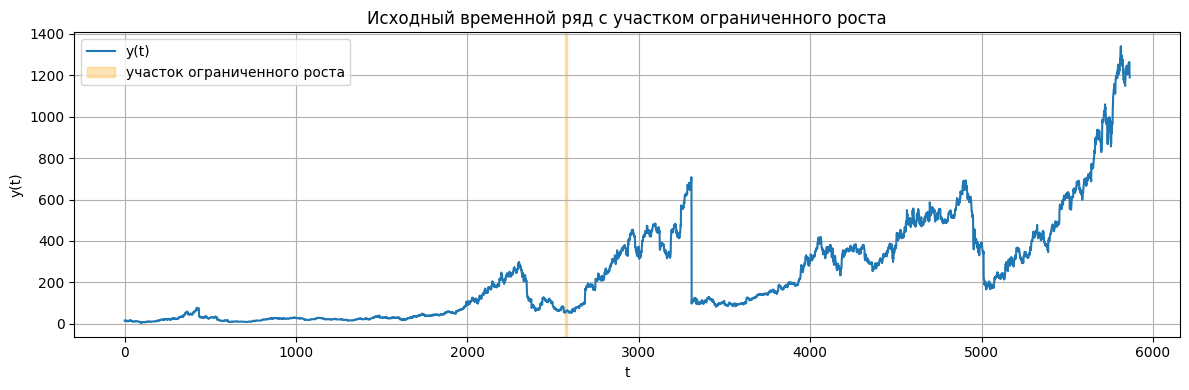

In [40]:
#построение анаморфозы ограниченного роста
y_s = pd.Series(y).rolling(window=5, center=True).mean().to_numpy()
t = np.arange(len(y))
mask = ~np.isnan(y_s)
t_clean = t[mask]
y_clean = y_s[mask]

y_cumulative_max = pd.Series(y_clean).expanding().max().to_numpy()
gompertz_anamorf = np.log(np.maximum(y_clean / y_cumulative_max, 1e-10))

gompertz_smooth = pd.Series(gompertz_anamorf).rolling(window=5, center=True).mean().to_numpy()
mask2 = ~np.isnan(gompertz_smooth)
t_seg = t_clean[mask2]
gompertz_vals = gompertz_smooth[mask2]

if len(t_seg) == 0:
    print("Недостаточно данных для анализа анаморфозы Гомперца.")
else:
    peaks, _ = find_peaks(gompertz_vals, prominence=0.1)
    troughs, _ = find_peaks(-gompertz_vals, prominence=0.1)
    extrema = np.sort(np.concatenate([peaks, troughs]))

    segments = []
    window_min = 5  # минимальная длина сегмента

    for i in range(len(extrema) - 1):
        start = extrema[i]
        end = extrema[i + 1] + 1  # включительно

        if end - start < window_min:
            continue

        t_win = t_seg[start:end].reshape(-1, 1)
        y_win = gompertz_vals[start:end]

        if len(y_win) < 3:
            continue

        # Проверка монотонности не требуется для Гомперца, но можно проверить динамику при желании
        model = LinearRegression().fit(t_win, y_win)
        slope = float(model.coef_[0])
        intercept = float(model.intercept_)
        r2 = model.score(t_win, y_win)

        if r2 >= 0.7 and abs(slope) > 1e-6:
            segments.append({
                "start": start,
                "end": end,
                "slope": slope,
                "intercept": intercept,
                "r2": r2,
            })

    # Сортируем по R² и берём лучший
    segments = sorted(segments, key=lambda x: x["r2"], reverse=True)
    print(f'Количество найденных сегментов = {len(segments)}')

    for i, seg in enumerate(segments[:5]):
        s, e = seg["start"], seg["end"]
        print(f"{i}: t≈[{t_seg[s]}, {t_seg[e-1]}], R²={seg['r2']:.4f}, "
              f"slope={seg['slope']:.4g}, intercept={seg['intercept']:.4g}")

    if segments:
        seg = segments[0]
        s, e = seg["start"], seg["end"]
        slope, intercept, r2 = seg["slope"], seg["intercept"], seg["r2"]

        # Вычисляем K и ln(K)
        K = -slope  # в модели Гомперца dy/dt / y ≈ -K * ln(y/y_max), а наклон = d/dt ln(y/y_max) ~ -K -> slope ≈ -K
        lnK = np.log(abs(K)) if K != 0 else np.nan

        # Находим t* как пересечение линейной модели с y = lnK
        if slope != 0:
            t_star = (lnK - intercept) / slope
        else:
            t_star = np.nan

        print(f"Выбранный сегмент: t≈[{t_seg[s]}, {t_seg[e-1]}], "
              f"slope={slope:.4g}, intercept={intercept:.4g}, R²={r2:.4f}")
        if not np.isnan(t_star):
            print(f"t*≈{t_star:.2f}, ln(K)={lnK:.4f}, K={K:.4g}")

        # === График 1: анаморфоза с сегментом и аппроксимацией ===
        plt.figure(figsize=(12, 4))
        plt.plot(t_seg, gompertz_vals, '.', ms=3, alpha=0.3, label="ln(y / y_max)")
        plt.plot(t_seg[s:e], gompertz_vals[s:e], 'r.', ms=4, label="сегмент роста")

        xs = t_seg[s:e]
        ys_fit = slope * xs + intercept
        plt.plot(xs, ys_fit, 'k-', label=f"линейная модель, R²={r2:.3f}")

        if not np.isnan(lnK):
            plt.axhline(y=lnK, color='orange', linestyle=':', linewidth=2, label=f"ln(K) = {lnK:.3f}")
            '''if not np.isnan(t_star):
                plt.axvline(x=t_star, color='red', linestyle='-', linewidth=2)
                plt.plot(t_star, lnK, 'ro', markersize=6)
                plt.text(t_star, lnK, f' t*≈{t_star:.1f}', fontsize=10,
                         bbox=dict(boxstyle="round,pad=0.2", facecolor="red", alpha=0.7))'''

        plt.xlabel("t")
        plt.ylabel("ln(y / y_max)")
        plt.title("Анаморфоза ограниченного роста (Гомперца)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === График 2: исходный ряд с участком и t* ===
        t_full = np.arange(len(y))
        plt.figure(figsize=(12, 4))
        plt.plot(t_full, y, label="y(t)")
        plt.axvspan(t_seg[s], t_seg[e-1], color='orange', alpha=0.3, label="участок ограниченного роста")

        plt.xlabel("t")
        plt.ylabel("y(t)")
        plt.title("Исходный временной ряд с участком ограниченного роста")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        print("Линейных сегментов (по нашим критериям) не найдено.")